# 2 - Exercise

### 1. What is the cache capacity of the computer you used (please write the workstation name)?

lab6p1 ([i5-8500](https://www.cpu-world.com/CPUs/Core_i5/Intel-Core%20i5%20i5-8500.html))

`lscpu`

L1d cache:                       192 KiB
L1i cache:                       192 KiB
L2 cache:                        1.5 MiB
L3 cache:                        9 MiB

| **Array Size**        | 4k |8k | 16k | 32k|64k |  128k | 256k  | 512k  |  1024k | 2048k | 4096k |
|-----------------------|-|--|-|-|-|-------|-------|-------|--------|-------|-------|
| **t2-t1**             | 0.000930| 0.001814 |0.003572 |0.007087 |0.013366 |   0.026765    |   0.053982    |   0.107694    |    0.215276   |   0.430951  |   0.863898    |
| **# accesses a[i]**   |400 | 800 |1600 | 3200|6400 |   12800    |   25600    |    51200   |    102400    |    204800   |    409600   |
| **# mean access time**| 0.000002325 | 0.000002268 | 0.000002232 | 0.000002215| 0.000002088|   0.000002091    |   0.000002109    |   0.000002103    |    0.000002102    |    0,000002104   |    0.000002109   |

In [1]:
from itertools import count
from math import log2


memo_num_accesses = {}


def num_accesses(array_size):
    """Array size in KiB"""

    key = array_size
    if key in memo_num_accesses:
        return memo_num_accesses[key]

    array_size = array_size << 10

    N_REPETITIONS = 100

    STRIDE_MAX = 2

    counter = 0
    stride = 1

    for stride in range(1, STRIDE_MAX, stride):

        limit = array_size - stride + 1

        # warm up
        ## for i in range(0, limit, stride ):
        ## counter+= 1

        # main loop
        for repeat in range(0, N_REPETITIONS * stride):
            counter += (limit - 0) / stride

    counter = int(counter)
    memo_num_accesses[key] = counter

    return counter


for size in range(2, 13):
    size_kb = 1 << size
    print(f"{size_kb: >4} KiB\t{num_accesses(size_kb)}")

   4 KiB	409600
   8 KiB	819200
  16 KiB	1638400
  32 KiB	3276800
  64 KiB	6553600
 128 KiB	13107200
 256 KiB	26214400
 512 KiB	52428800
1024 KiB	104857600
2048 KiB	209715200
4096 KiB	419430400


In [2]:
import pandas as pd

In [3]:
df = pd.DataFrame()
for i in range(8):
    df = pd.concat((df, pd.read_csv(f"./data/spark{i:0>2}.tsv", delimiter="\t")))

df = df.reset_index()

In [4]:
df_avg = df.groupby(["size", "stride"], as_index=False).mean().drop("index", axis=1)

df_avg

,size,stride,elapsed(s),cycles
0,4096,1,0.000939,939.250
1,4096,2,0.000918,917.500
2,4096,4,0.000901,900.625
3,4096,8,0.000887,887.250
4,4096,16,0.000914,914.250
...,...,...,...,...
182,4194304,131072,3.450860,3450860.125
183,4194304,262144,2.549151,2549151.125
184,4194304,524288,0.961996,961996.000
185,4194304,1048576,0.891310,891309.750


In [5]:
df_avg["accesses"] = df_avg["size"].apply(lambda x: num_accesses(x >> 10))
df_avg["mean_access_time"] = df_avg["elapsed(s)"] / df_avg["accesses"]

In [6]:
df_avg[df_avg["stride"] == 1].sort_values("size")

,size,stride,elapsed(s),cycles,accesses,mean_access_time
0,4096,1,0.000939,939.250,409600,2.292480e-09
12,8192,1,0.001844,1847.125,819200,2.250366e-09
25,16384,1,0.003591,3591.125,1638400,2.191772e-09
39,32768,1,0.007141,7141.250,3276800,2.179222e-09
54,65536,1,0.013441,13440.500,6553600,2.050877e-09
70,131072,1,0.026922,26921.375,13107200,2.053967e-09
87,262144,1,0.053918,53918.500,26214400,2.056823e-09
105,524288,1,0.107772,107771.625,52428800,2.055581e-09
124,1048576,1,0.215631,215630.750,104857600,2.056419e-09
144,2097152,1,0.431647,431646.875,209715200,2.058253e-09


### 2. What is the cache capacity of the computer?

64kiB

### 3. What is the size of each cache block?

16B

### 4. What is the L1 cache miss penalty time?

In [7]:
1000 - 360

640

# 3 - Procedure

### 3.1 Modeling Computer Caches
In the first part of this assignment, the goal is to model the characteristics of the L1 data cache and L2
cache of the targeted computer platform. Next, we provide instructions for performing this analysis.
Use the forms at the end to answer the questions below.

#### 3.1.1 Modeling the L1 Data Cache

a) Change to directory cm1/, in the package lab2_kit.zip, and analyze de code of the program
cm1.c. Identify its source code with the program described above.

What are the processor events that will be analyzed during its execution? Explain their meaning.

> The event analized in the `cm1.c` program is `PAPI_L1_DCM`, which means, "L1 Data Cache Misses".  
> This means that we will analize how many data cache misses, that is, how many times we tried to fetch data that was not in the L1 cache, during the execution of the program.

b) Compile the program cm1.c using the provided Makefile and execute cm1. 

Plot the variation of
the average number of misses (Avg Misses) with the stride size, for each considered dimension
of the L1 data cache (8kB, 16kB, 32kB and 64kB).

Note that, you may fill these tables and graphics (as well as the following ones in this report)
on your computer and submit the printed version.

NOTE: A fast sketch of these plots can be drawn in your computer by running the following commands:
./cm1 > cm1.out
./cm1_proc.sh

NOTE 2: You can draw these tables and plots on your computer, print, and attach to the report. You do not have to fill them by hand on the printed report.

NOTE 3: You may need to mark the script as executable before being able to run it.

In [8]:
def strip_labels(val):
    value = val.split("=")[1]
    return float(value) if "." in value else int(value)


df = pd.DataFrame()
for i in range(10):
    df = pd.concat(
        (
            df,
            pd.read_csv(
                f"./data/cm1_data{i:0>2}.tsv",
                delimiter="\t",
                names=["cache_size", "stride", "avg_misses", "avg_time"],
                converters={
                    "cache_size": strip_labels,
                    "stride": strip_labels,
                    "avg_misses": strip_labels,
                    "avg_time": strip_labels,
                },
            ),
        )
    )

df = df.reset_index()

In [9]:
df_avg = (
    df.groupby(["cache_size", "stride"], as_index=False).median().drop("index", axis=1)
)

df_avg.head()

,cache_size,stride,avg_misses,avg_time
0,8192,1,0.000217,0.004070
1,8192,2,0.000213,0.004347
2,8192,4,0.000098,0.004082
3,8192,8,0.000106,0.003149
4,8192,16,0.000131,0.002867


In [10]:
import drawSvg as draw

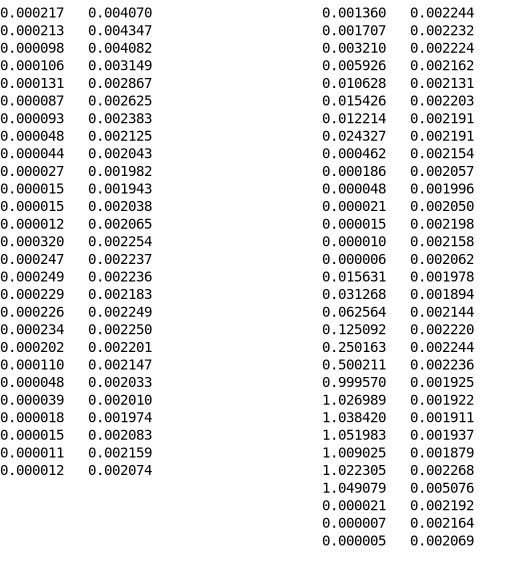

In [11]:
d = draw.Drawing(300, 320)

for y, i in zip(range(310, 40, -10), range(0, 27)):
    d.append(
        draw.Text(
            f"{df_avg['avg_misses'][i]:.6f}", 8, 0, y, style="font-family: 'monospace'"
        )
    )

for y, i in zip(range(310, 40, -10), range(0, 27)):
    d.append(
        draw.Text(
            f"{df_avg['avg_time'][i]:.6f}",
            8,
            0 + 50,
            y,
            style="font-family: 'monospace'",
        )
    )

for y, i in zip(range(310, 0, -10), range(27, 58)):
    d.append(
        draw.Text(
            f"{df_avg['avg_misses'][i]:.6f}",
            8,
            183,
            y,
            style="font-family: 'monospace'",
        )
    )

for y, i in zip(range(310, 0, -10), range(27, 58)):
    d.append(
        draw.Text(
            f"{df_avg['avg_time'][i]:.6f}",
            8,
            183 + 50,
            y,
            style="font-family: 'monospace'",
        )
    )

d.setPixelScale(1.76)

d

In [12]:
import seaborn as sns
import matplotlib as mpl

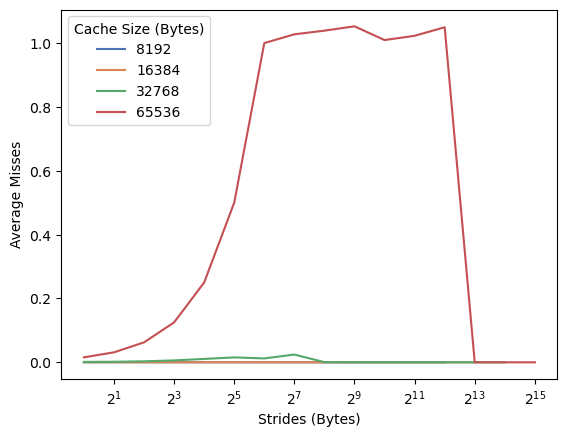

In [13]:
g_results = sns.lineplot(
    data=df_avg, x="stride", y="avg_misses", hue="cache_size", palette="deep"
)
g_results.set_xscale("log", base=2)
g_results.set_xlabel("Strides (Bytes)")
g_results.set_ylabel("Average Misses")
g_results.get_legend().set_title("Cache Size (Bytes)")

c) By analyzing the obtained results:

• Determine the **size** of the L1 data cache. Justify your answer.

In [14]:
# DATA
l1_max_cache_size = 1 << 5  # in KiB, the last line that stays flat

In [15]:
print(f"L1 cache size = {l1_max_cache_size} KiB")

L1 cache size = 32 KiB


> We can determine the cache size by looking at the plot and finding the greatest
> test cache size that always has "average misses" as zero.
> In this case, the **green line (32KiB)** is the size that matches this description.
> It has a small bump at stride 2^7, but it can be ignored due to the cache being occupied by other data from the program.

• Determine the **block size** adopted in this cache. Justify your answer.

In [16]:
# DATA
l1_block_size = 1 << 6  # in bytes; when the line gets flat

In [17]:
print(f"L1 block size = {l1_block_size} B")

L1 block size = 64 B


> When stride is less than **64 Bytes**, the miss rate keeps increasing, which means
> that there are some accesses that keep hitting the cache, that is, they are inside
> the same block as the previous access.  
> Once the plot flattens, it means we've broken outside the bounds of the block,
> that is, sequential accesses are on different blocks.
> For this reason, we know that the block size is **64 Bytes**.

• Characterize the **associativity set size** adopted in this cache. Justify your answer.

In [18]:
# DATA
l1_first_back_to_zero = (
    13  # first stride where cache miss of largest cache (2^16) goes back to zero
)

In [19]:
l1_associativity_set_size = 1 << (16 - l1_first_back_to_zero)

print(f"L1 associativity set size = {l1_associativity_set_size}")

L1 associativity set size = 8


To determine the associativity set size, we have to analyze in which stride size
the miss rate decreases back to zero for the largest cache (that is, red line **64KiB**).
Because the stride determines how many blocks of array data we're going to access, we
know that for a stride of 2^15 (the maximum for this array size) we're only going
to access 2 different blocks of this cache. If the cache is, at least, 2-way associative,
we're going to have a near-zero miss rate.  
If we repeat this process for lower strides, we notice that for 2^14 and 2^13 the
miss rate is also near-zero. This must mean the cache is, at least, 4-way or 8-way associative,
respectively.
For a lower stride of 2^12, this is no longer the case, so we must have surpassed
the number of ways of our cache.

Therefore, the associativity set size must be 8.

#### 3.1.2 Modeling the L2 Cache
In this part of the assignment, the goal is to experimentally model the characteristics of the L2 cache of the targeted computer platform. To analyze the computer’s L2 cache, we will use the same methodology that was introduced in the previous section to model the L1 data cache.

a) Modify the program cm1.c in order to analyze the characteristics of the L2 cache. (Hint: use the
event PAPI_L2_DCM.)

_Describe and justify the changes introduced in this program._

> We've changed two things:
> - the PAPI event, which we've changed from `PAPI_L1_DCM` to `PAPI_L2_DCM`,
>   since we want to measure the miss rate of the L2 cache now.
> - the `CACHE_MAX` value has been increased to 1MiB, since the L2 is much larger than the L1.

b) Compile the program cm1.c, execute cm1, and plot the variation of the average number of misses
(Avg Misses) with the stride size, for each considered dimension of the L2 cache.

In [20]:
def strip_labels(val):
    value = val.split("=")[1]
    return float(value) if "." in value else int(value)


df = pd.DataFrame()
for i in range(1):
    df = pd.concat(
        (
            df,
            pd.read_csv(
                f"./data/cm1_l2_data{i:0>2}.tsv",
                delimiter="\t",
                names=["cache_size", "stride", "avg_misses", "avg_time"],
                converters={
                    "cache_size": strip_labels,
                    "stride": strip_labels,
                    "avg_misses": strip_labels,
                    "avg_time": strip_labels,
                },
            ),
        )
    )

df = df.reset_index()

In [21]:
df_avg = (
    df.groupby(["cache_size", "stride"], as_index=False).median().drop("index", axis=1)
)

df_avg.head()

,cache_size,stride,avg_misses,avg_time
0,8192,1,0.000090,0.004299
1,8192,2,0.000016,0.003986
2,8192,4,0.000001,0.002406
3,8192,8,0.000001,0.002403
4,8192,16,0.000000,0.002419


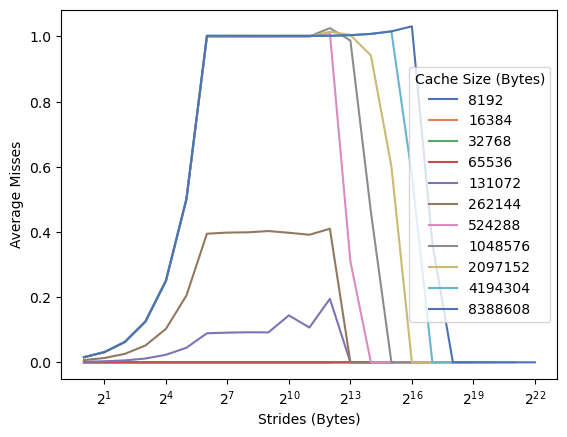

In [22]:
g_results = sns.lineplot(
    data=df_avg, x="stride", y="avg_misses", hue="cache_size", palette="deep"
)
g_results.set_xscale("log", base=2)
g_results.set_xlabel("Strides (Bytes)")
g_results.set_ylabel("Average Misses")
g_results.get_legend().set_title("Cache Size (Bytes)")

c) By analyzing the obtained results:

• Determine the size of the L2 cache. Justify your answer.

In [23]:
# DATA
l2_max_cache_size = 1 << 8  # in KiB, the last line that doesn't have a miss rate of 1

In [24]:
print(f"L2 cache size = {l2_max_cache_size} KiB")

L2 cache size = 256 KiB


> We can determine the cache size by looking at the plot and finding the greatest
> test cache size that doesn't have a miss rate of 1 when it stabilizes.
> In this case, the **brown line (256KiB)** is the size that matches this description.

• Determine the block size adopted in this cache. Justify your answer.

In [25]:
# DATA
l2_block_size = 1 << 6  # in bytes; when the line gets flat

In [26]:
print(f"L2 block size = {l1_block_size} B")

L2 block size = 64 B


> When stride is less than **64 Bytes**, the miss rate keeps increasing, which means
> that there are some accesses that keep hitting the cache, that is, they are inside
> the same block as the previous access.  
> Once the plot flattens, it means we've broken outside the bounds of the block,
> that is, sequential accesses are on different blocks.
> For this reason, we know that the block size is **64 Bytes**.

• Characterize the associativity set size adopted in this cache. Justify your answer.

> // TODO!!  
5 way

### 3.2 Profiling and Optimizing Data Cache Accesses

#### 3.2.1 Straightforward implementation

a) Change to directory mm1/ and analyze de code of the program mm1.c. Identify its source code
with the program described above.

What is the total amount of memory that is required to accommodate each of these matrices?

In [27]:
1024 * 1024 * 2

2097152

b) Compile the source file mm1.c using the provided Makefile and execute it. 

Fill the table with the obtained data.

In [28]:
27922.538605 + 5372.911679

33295.450284

|                                                       |     **Data**    |
|-------------------------------------------------------|-----------------|
| **Total number of L1 data cache misses**              |    $1073.613982 \times 10^6$|
|**Total number of load / store instructions completed**|    $33295.450284 \times 10^6$|
| **Total number of clock cycles**                      |    $21932.078232 \times 10^6$|
| **Elapsed time**                                      |      7.310727    seconds|

c) Evaluate the resulting L1 data cache Hit-Rate.

In [29]:
1073.613982 / 33295.450284

0.03224506570244287

3,2% de data cache miss, as matrizes não cabem todss na L1.

### 3.2.2 First Optimization: Matrix transpose before multiplication [2]

a) Change to directory mm2/ and analyze the code of the program mm2.c. Identify its source code
with the program described above. Compile this program using the provided Makefile and execute it.

Fill the table with the obtained data

In [30]:
3221.225575 + 1073.741876

4294.967451

> TODO

|                                                       |     **Data**    |
|-------------------------------------------------------|-----------------|
| **Total number of L1 data cache misses**              |    $33.635765 \times 10^6$|
|**Total number of load / store instructions completed**|    $4294.967451 \times 10^6$|
| **Total number of clock cycles**                      |    $4190.571197 \times 10^6$|
| **Elapsed time**                                      |       1.396863   seconds|

b) Evaluate the resulting L1 data cache Hit-Rate.

In [31]:
33.635765 / 4294.967451

0.007831436532113547

0.7% de data cache misses

c) Change the code in the program mm2.c in order to include the matrix transposition in the execution
time. Compile this program using the provided Makefile and execute it.

Fill the table with the obtained data.

Comment on the obtained results when including the matrix transposition in the execution time.

In [32]:
4.216389 + 134.217780

138.434169

> TODO

|                                                       |     **Data**    |
|-------------------------------------------------------|-----------------|
| **Total number of L1 data cache misses**              |    $4.216389 \times 10^6$|
|**Total number of load / store instructions completed**|    $138.434169 \times 10^6$|
| **Total number of clock cycles**                      |    $613.837153 \times 10^6$|
| **Elapsed time**                                      |        0.204612  seconds|

In [33]:
4.216389 / 138.434169

0.0304577188598575

3% de data cache miss

d) Compare the obtained results with those that were obtained for the straightforward implementation,
by calculating the difference of the resulting hit-rates (∆HitRate) and the obtained speedups.

In [34]:
0.0304577188598575 - 0.007831436532113547

0.022626282327743955

In [35]:
4190.571197 / 613.837153

6.826845160022435

In [36]:
1.396863 / 0.204612

6.826886986100522

|                                                       |     **Data**    |
|-------------------------------------------------------|-----------------|
| **$\Delta$ Hit Rate = HitRate mm2 - HitRate mm1**              |    0.022626282327743955|
|**Speedup(#Clocks) = #Clocks mm1 / #Clocks mm2**|    6.826845160022435|
| **Speedup(Time) = Time mm1 / Time mm2**                      |    6.826886986100522|


> TODO

### 3.2.3 Second Optimization: Blocked (tiled) matrix multiply [2

a) Change to directory mm3/ and analyze the code of the program mm3.c. Identify its source code
with the program described above.

Change the program source code in order to comply the algorithm parameterization (sub-matrix
line size) with the block size (CLS) that was determined in Section 3.1.

How many matrix elements can be accommodated in each cache line?

> TODO

b) Compile this program using the provided Makefile and execute it. 

Fill the table with the obtained data

> TODO

|                                                       |     **Data**    |
|-------------------------------------------------------|-----------------|
| **Total number of L1 data cache misses**              |    $\times 10^6$|
|**Total number of load / store instructions completed**|    $\times 10^6$|
| **Total number of clock cycles**                      |    $\times 10^6$|
| **Elapsed time**                                      |          seconds|

c) Evaluate the resulting L1 data cache Hit-Rate.

> TODO

d) Compare the obtained results with those that were obtained for the straightforward implementation,
by calculating the difference of the resulting hit-rates (∆HitRate) and the obtained speedup.

> TODO

e) Compare the obtained results with those that were obtained for the matrix transpose implementation by calculating the difference of the resulting hit-rates (∆HitRate) and the obtained speedup.

If the obtained speedup is positive, but the difference of the resulting hit-rates is negative, how
do you explain the performance improvement? 

(Hint: study the hit-rates of the L2 cache for both
implementations; You may use the following PAPI events PAPI_L2_DCH (or PAPI_L2_DCM)
and PAPI_L2_DCA. Run papi_avail to check for available events and understand their meaning.)

> TODO